# Currents

**This is a Literate Notebook.**

## Motivation

Current can be the determining factor in many races, particularly in regions with large tidal flows (like the Puget Sound and other popular sailing areas such as England and the Atlantic coast of France).  We'll use the PNW as a concrete example.

- Tides can be up to 14 ft, so there is a lot of flow.
- Current in the center of a channel can be strong, up to 2kts.
  - Most often its less than a 1kt; in narrow channels (Agate Pass) it can be 5kts.
- There can be significant back eddy counterflows.
- Current when running opposite to winds can increase waves.

In general, 0.2kts can make the difference between a win and a loss. 

![im](Data/Images/current_tidal_current.png)

Above, an example of NOAA predicted tidal currents from the Puget Sound.  Below, a "tide print" which shows a much higher resolution picture of back eddies.  This first is from [Tidal Currents of the Puget Sound](https://www.starpath.com/catalog/books/1986.htm) the second from [Tide Prints](https://eos.ucs.uri.edu/seagrant_Linked_Documents/washu/washum77001.pdf) (which appears to be out of print, but provides the high image quality).

![im](Data/Images/current_tide_print.png)

There are multiple sources of current data, and we will use them all:

- NOAA collects current data at multiple depths and multiple locations over a period of weeks. [Link](https://tidesandcurrents.noaa.gov/cdata/StationList?type=Current+Data&filter=historic&pid=36)
  - This data is then used to predict currents in the future... most likely using references to the "Harmonic Constituents" used to predict the tides.
  
- The University of Washington has study tidal flows in the Puget Sound for many, many years. In the 50's they built a physical scale model, the [Puget Sound Oceanographic Model](https://www.eopugetsound.org/articles/puget-sound-model-summary), and then used it to measure flows.  Using 1950's era tools (i.e. floating bits of foam and long exposure images) they captured these flows and published them in Tide Prints (above).  The direction of the flows (set) are considered accurate, but the magnitude (drift) are not.  There may also be issues with timing.  See this awesome [video](https://youtu.be/0-2y_j66xAE) to give you a sense of how this worked.

> “The tide-generating equipment of the model was set to repeat continuously the selected tidal-day sequence. Small particles of white polystyrene foam were distributed as uniformly as possible over the surface of the water which had been dyed a dark color to provide suitable contrast for photography. A series of eight two-second, time-exposure photographs was taken during the tidal day, with the start of each exposure precisely timed with reference to the tide stage at Seattle. During the two- second exposure time, the movement of the water caused the floating particles to appear in the photographs as streaks which indicated flow lines. Although the individual streak lengths were a function of current speed,
they were not a reliable measure because of image overlapping produced by the great number of closely spaced particles required to obtain suitable detail of the flow patterns.”

- As we sail we collect measurements of absolute position (SOG/COG) and the speed through the water (SPD/HDG).  The difference is principally current (though the boat also undergoes a drift to leeward called leeway).


Some additional links:
- Wikipedia on tides
  - https://en.wikipedia.org/wiki/Theory_of_tides
  - https://en.wikipedia.org/wiki/Tide#Constituents
  
- UW's more recent work understand flows in the Puget Sound.
  - http://faculty.washington.edu/pmacc/LO/tides_background.html
  - http://faculty.washington.edu/pmacc/LO/P_tracks_barber.html
  - http://www.prism.washington.edu/story/Validating+the+circulation+model
  - https://salish-sea.pnnl.gov/
  - Got to figure this out... looks like a modern computer version of the "particle tracks" from the 


## Overview

The basic plan is related to the work on charting.

Step one is to be able to align all this data.  There is easy way to compare measurements of current, or integrate them together, without an accurate alignment.

Let's start with the hardest data: the Tide Prints, which are produced by hand.  The highest quality images we have are scanned with clear though minor scanning artifacts (from the University of Rhode Island library).  The individual images are not geo-registered;  lat/lon lines to appear but without labels.  Referring to the first map in the section you can find labels.

![im](Data/Images/current_base_map.jpg)

Seven lat/lon crossing are both clear, and labeled.  See code below for the coordinates of these crossings.


In [1]:
# Import some basic libraries
import os
import copy

import numpy as np
import cv2

# These are libraries written for RegattaAnalysis
from global_variables import G  # global variables
import race_logs
import chart as ch
from latlonalt import LatLonAlt as lla
from utils import DictClass

import nbutils
from nbutils import display_markdown, display

In [2]:
# notebook - initialize

# Note matplotlib must be loaded *after* nbutils (to ensure Jupyter setup)
import matplotlib
import matplotlib.pyplot as plt

G.init_seattle()

In [4]:
# Based on examination of the base map, these are the lat/lon coordinates of visible
# crossing.  In order from left to right, bottom first (or equivalently first southernmost
# first, and then from west to east).

LANDMARKS = [lla.from_degrees_minutes(lat_dm=(47, 20), lon_dm=(-122, 30)),
             lla.from_degrees_minutes(lat_dm=(47, 20), lon_dm=(-122, 20)),
             lla.from_degrees_minutes(lat_dm=(47, 30), lon_dm=(-122, 40)),
             lla.from_degrees_minutes(lat_dm=(47, 30), lon_dm=(-122, 20)),
             lla.from_degrees_minutes(lat_dm=(47, 40), lon_dm=(-122, 40)),
             lla.from_degrees_minutes(lat_dm=(47, 40), lon_dm=(-122, 20)),                  
             lla.from_degrees_minutes(lat_dm=(47, 50), lon_dm=(-122, 20))]

TIDE_PRINT_DIR = "Data/Currents/TidePrints"
TIDE_PRINT_FILES = [f"im-{i:03d}.jpg" for i in range(24, 33)]
TIDE_PRINT_PATHS = [os.path.join(TIDE_PRINT_DIR, f) for f in TIDE_PRINT_FILES]

In [5]:
# notebook 

display_markdown("Coordinates of the crossings in order from left to right, bottom first (or equivalently southernmost first, and then from west to east")

for l in LANDMARKS:
    print(l)

Coordinates of the crossings in order from left to right, bottom first (or equivalently southernmost first, and then from west to east

47.333333N 122.500000W
47.333333N 122.333333W
47.500000N 122.666667W
47.500000N 122.333333W
47.666667N 122.666667W
47.666667N 122.333333W
47.833333N 122.333333W


## Finding the landmarks on the map image

If we can register these known lat/lon landmarks to points on the map, we can then georeference the map.

We can achieve this by selecting points on the map, being careful to preserve the order (bottom to top, left to right).

In [6]:
def capture_tide_print_landmarks():
    """
    This is a one-time function that is run to capture the landmarks on a set of maps.
    Once it is done the results should be stored away in datastructure.
    """
    return capture_landmarks(TIDE_PRINT_PATHS)


def capture_landmarks(images):
    "Capture landmarks for a sequence of images."
    res = []
    for path in images:
        res.append(pick_image_landmarks(path))
        # Since previous function is asynchronous and returns immediately, you need to
        # block before bringing up the next image.
        plt.show(block=True)  # Note, block does not make sense in notebooks.
    return res


def pick_image_landmarks(image_path):
    """
    Load image, display, and collect clicked points.

    Result: dict that contains points and file names.

    Asynchronous function, which returns immediately.  Results are updated after clicking.    
    """
    _, file = os.path.split(image_path)
    G.logger.info(f"Processing file {file}")
    im = cv2.imread(image_path)
    if im is not None:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        display("Pick the points left to right, starting at the bottom.")
        res = pick_points(im)
        # Block until window is closed.
        res.file = file
        res.path = image_path
        return res
    else:
        raise Exception(f"Missing file {path}")


def pick_points(im, fig=None):
    """
    Pick points on an image and collect the points into a list.  Coordinates are in pixels.
    Asynchronous function, which returns immediately.  Results are updated after clicking.

    Collects a numpy array, rows are points, col 0 is x, col 1 is y.    

    Returns a result, a dict such that result['points'] = collected points.

    Note, x goes from east to west.  And y goes from north to south.
    """
    display("If you want to replace a point, simply click nearby the existing point.")
    fig, ax = plt.subplots(1, 1, num=None)
    fig.tight_layout()
    ax.imshow(im)
    drawn_points = ax.plot(0, 0, linestyle = 'None', marker='+', markersize=100, color='red')[0]
    # Python's handling of lexical scoping is strange.  The callbacks below need to modify
    # the points, by wrapping it in a dict, we are not reassigning a lexical variable.
    result = DictClass(points=None)
    result.height, result.width, _ = im.shape

    def add_point(x, y, min_distance=200):
        "Add a point, but if its closer that MIN_DISTANCE, then replace existing."
        new_row = np.array([[x, y]])
        current_points = result.points
        display(current_points)
        if current_points is None:
            result.points = new_row
        else:
            distances = np.sqrt(np.square(current_points - new_row).sum(1))
            small_distances = distances < min_distance
            if np.any(small_distances):
                close_row = np.argmax(small_distances)
                G.logger.info(f"Replacing row {close_row}")
                current_points[close_row, :] = new_row
                print(current_points)
            else:
                G.logger.info(f"Adding row {new_row}")
                result.points = np.append(current_points, new_row, axis=0)

    def onpress(event):
        # Only pick the points if shift clicking
        if event.key == 'shift':
            G.logger.info(f"you pressed, {event.button}, {event.key}, {event.xdata}, {event.ydata}")
            add_point(event.xdata, event.ydata)
            x = result.points[:, 0]
            y = result.points[:, 1]
            drawn_points.set_data(x, y)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('button_press_event', onpress)
    return result

In [10]:
# notebook - capture landmarks

def capture_tide_print_landmarks(images):
    """
    This is a one-time function that is run to capture the landmarks on a set of maps.
    Once it is done the results should be stored away in datastructure.
    """
    return capture_landmarks(images)

if False:
    landmarked_images = capture_tide_print_landmarks(TIDE_PRINT_PATHS[:1])

# Note the code above run asynchronously.  After you are done clicking the points are available in the result.

In [11]:
# notebook - the results of lots of clicking

# Set of tide print images, and points picked at the intersection of visible lat/lon
# lines.  The points are in <x, y> or <east, south> (the upper right corner is x=0, y=0,
# so increasing x moves east, and increasing y moves south).  The point order is lowest
# first, and then left to right (or southernmost first, and then west to east).
LANDMARKED_IMAGES = [
    {'points': [[866.8971738496723, 2187.633598589958],
                [1270.8041320634777, 2187.633598589958],
                [467.12376637782114, 1598.8978714859172],
                [1270.213624814627, 1599.488378734768],
                [465.3522446312693, 997.1709849071635],
                [1268.442103068075, 997.7614921560141],
                [1266.6705813215235, 400.758663568065]],
     'file': 'im-024.jpg',
     'path': 'Data/Currents/TidePrints/im-024.jpg',
     'height': 2210,
     'width': 1687},
    {'points': [[632.4514473323952, 2183.818054285506],
                [1029.419738836522, 2185.001268269125],
                [236.0747628200781, 1592.211062476078],
                [1030.6029528201407, 1596.9439184105536],
                [236.66636981188753, 991.7299657895089],
                [1031.786166803759, 996.4628217239843],
                [1032.3777737955684, 399.5313669882713]],
     'file': 'im-025.jpg',
     'path': 'Data/Currents/TidePrints/im-025.jpg',
     'height': 2208,
     'width': 1680},
    {'points': [[862.1767610847924, 2173.004836878175],
                [1265.287930861859, 2173.717047425484],
                [463.3388545915819, 1584.0067142533799],
                [1266.0001414091682, 1586.143345895308],
                [461.9144334969631, 983.6132228716363],
                [1265.287930861859, 984.3254334189455],
                [1262.4390886726217, 386.78078422643887]],
     'file': 'im-026.jpg',
     'path': 'Data/Currents/TidePrints/im-026.jpg',
     'height': 2207,
     'width': 1684},
    {'points': [[638.520293439536, 2179.912388891763],
                [1036.660839627184, 2180.5423581104146],
                [241.63968568919074, 1589.6312310154563],
                [1035.4009011898813, 1592.781077108713],
                [242.89962412649345, 986.7506887661223],
                [1036.0308704085328, 992.4204117339843],
                [1038.5507472831382, 396.46953088981525]],
     'file': 'im-027.jpg',
     'path': 'Data/Currents/TidePrints/im-027.jpg',
     'height': 2205,
     'width': 1685},
    {'points': [[846.2342766313084, 2188.8551278277537],
                [1249.5768789040183, 2191.424188988726],
                [449.9565925512732, 1598.6133260942815],
                [1252.145940064991, 1603.7514484162266],
                [451.24112313175914, 998.7375450071617],
                [1253.4304706454768, 1001.9488714583775],
                [1253.4304706454768, 403.9998862419875]],
     'file': 'im-028.jpg',
     'path': 'Data/Currents/TidePrints/im-028.jpg',
     'height': 2208,
     'width': 1674},
    {'points': [[643.2031173650494, 2182.5686137273547],
                [1041.211401947505, 2180.405525224189],
                [241.58968527731798, 1596.371629369499],
                [1036.1641954401189, 1592.7664818642234],
                [237.9845377720422, 994.3119959884294],
                [1033.2800774358982, 993.5909664873743],
                [1029.6749299306223, 396.57853961369096]],
     'file': 'im-029.jpg',
     'path': 'Data/Currents/TidePrints/im-029.jpg',
     'height': 2204,
     'width': 1658},
    {'points': [[859.5546699632837, 2182.302318523807],
                [1263.747359447885, 2183.48937488059],
                [463.07784679777177, 1592.9288373810627],
                [1265.5279439830595, 1594.709421916237],
                [463.0778467977718, 991.0912644920971],
                [1265.5279439830595, 994.652433562446],
                [1265.5279439830595, 396.9695579222208]],
     'file': 'im-030.jpg',
     'path': 'Data/Currents/TidePrints/im-030.jpg',
     'height': 2203,
     'width': 1680},
    {'points': [[650.9656029235393, 2190.295434823486],
                [1047.2390997663624, 2189.0964227301642],
                [249.89605770742952, 1602.7795090958514],
                [1043.0425574397364, 1601.5804970025297],
                [245.88296317970742, 1002.8820277075587],
                [1039.734264181966, 1001.5622416709797],
                [1036.4347990905185, 405.67884615556864]],
     'file': 'im-031.jpg',
     'path': 'Data/Currents/TidePrints/im-031.jpg',
     'height': 2207,
     'width': 1665},
    {'points': [[843.9021975656472, 2175.9663282332654],
                [1247.7448116920702, 2179.191908218301],
                [449.7363233943299, 1583.7498429807792],
                [1252.905739668127, 1589.5558869538427],
                [451.94552536319543, 983.9061287309339],
                [1254.8002642882593, 989.2230475317622],
                [1254.135649438156, 391.06968243858546]],
     'file': 'im-032.jpg',
     'path': 'Data/Currents/TidePrints/im-032.jpg',
     'height': 2201,
     'width': 1680}]

'Displaying im-024.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


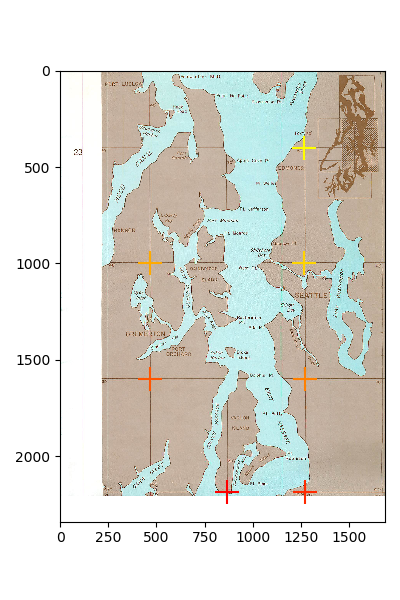

'Displaying im-025.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


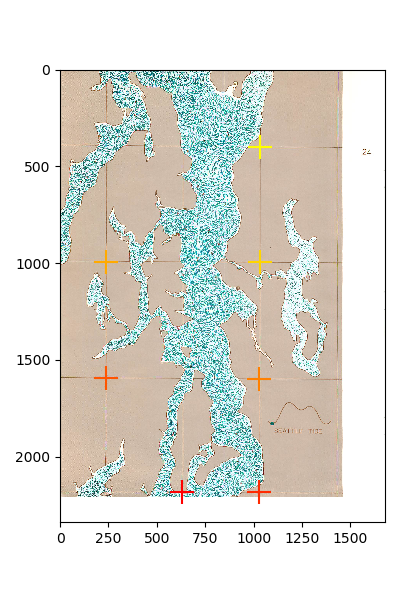

'Displaying im-026.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


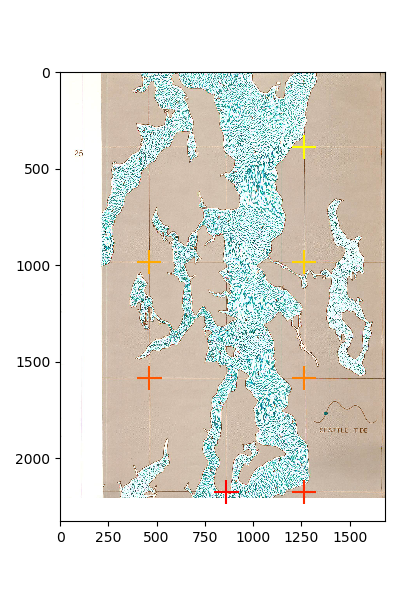

'Displaying im-027.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


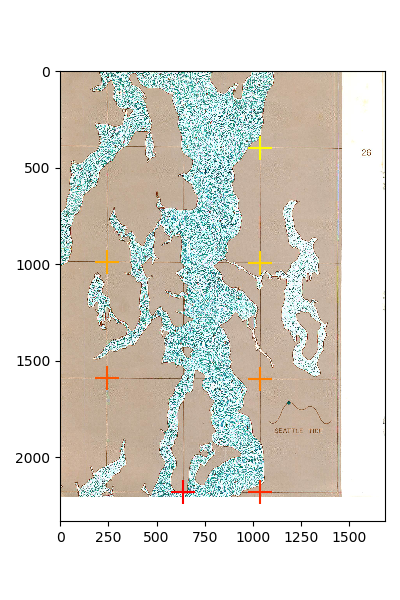

'Displaying im-028.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


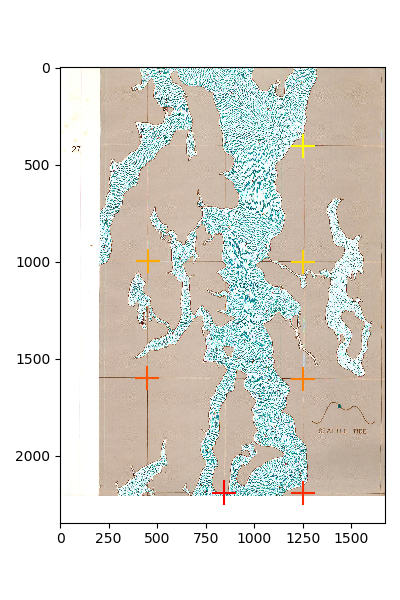

'Displaying im-029.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


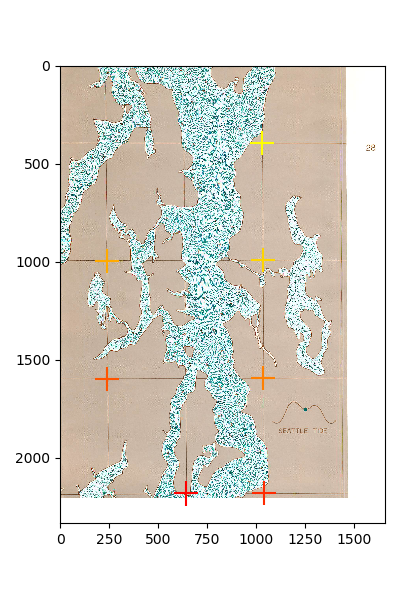

'Displaying im-030.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


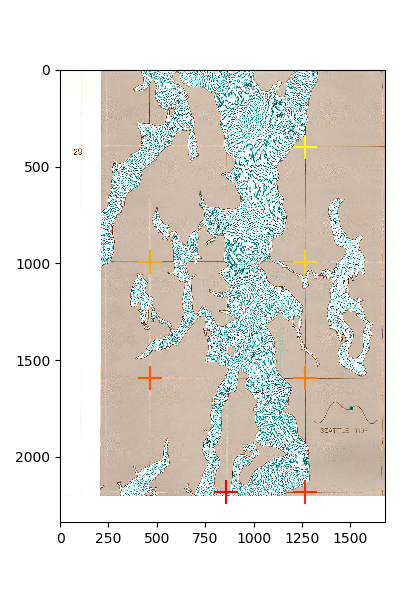

'Displaying im-031.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


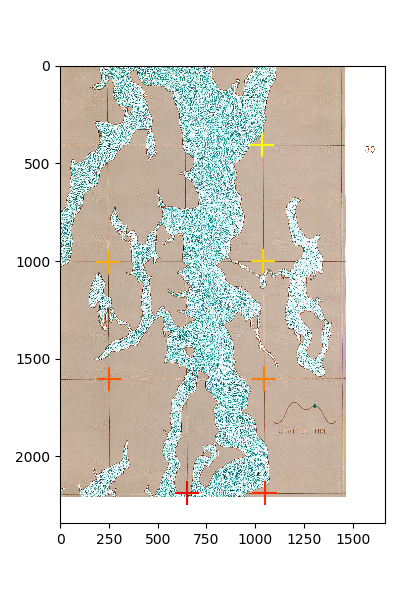

'Displaying im-032.jpg.  Close plot to proceed to next.'

<IPython.core.display.Javascript object>


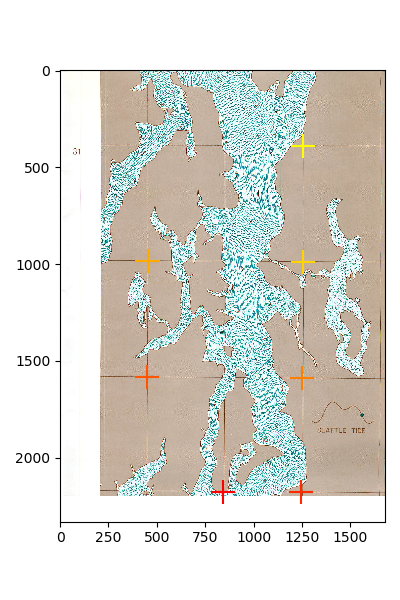

In [14]:
# notebook - visualization of the clicked points to confirm it was done correctly.

def check_landmarks():
    for pick in LANDMARKED_IMAGES:
        display(f"Displaying {pick['file']}.  Close plot to proceed to next.")
        check_points(pick)
        plt.show(block=True)

def check_points(landmarked_image):
    """
    Display the map and then plot the points.  Color (from red to yellow) is used to show
    the 'order' of the points.
    """
    pick = DictClass(**landmarked_image)
    im = cv2.imread(pick.path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(4, 6), num=None)
    ax.imshow(im)
    x = [p[0] for p in pick.points] 
    y = [p[1] for p in pick.points]
    colors = [matplotlib.cm.autumn(v) for v in np.linspace(0, 1, len(x))]
    ax.scatter(x, y, 300, marker='+', color=colors)
    fig.tight_layout()

check_landmarks()    

## Geo-referencing

OK, we now have the locations of lat/lon in the tide prints.  Now what?  One of the main goals is to resuse the code used to plot tracks on NOAA charts (see Chart_Module.ipynb).

There are lots of paths forward at this point, some very complex.  What was the projection of this map?  The datum?  Was the scan done carefully, keeping the longitudes vertical and the latitudes horizontal?

We are going to assume that the maps are in a straightforward projection and that the scans were performed carefully.  
Given the landmark locations in pixel coordinates and lat/lon we can estimate a matrix that transforms pixels coordinates to lat/lon coordinates.  In theory this matrix could model a rotation and a shearing.  In subsequent steps we 



In [16]:
def estimate_geo_transform(landmarked_image, lat_lon_coordinates):
    """
    Given a set of landmarks in an image AND a set of corresponding lat/lon coorinates,
    estimate the transformation from pixel coordinates to lat/lon.

    Note we will use homogenous coordinates, which ensures a two way transformation.
    """
    li = DictClass(**landmarked_image)
    pts = np.array(li.points)
    inputs = add_homogenous(pts)
    lat_col = [l.lat for l in LANDMARKS]
    lon_col = [l.lon for l in LANDMARKS]
    outputs = add_homogenous(np.array([lon_col, lat_col]).T)
    model, residuals, rank, singular_values = np.linalg.lstsq(inputs, outputs, rcond=None)
    G.logger.info(f"Found a model residuals {residuals}")
    return model

def add_homogenous(vecs):
    """
    Add a final column of all 1's, the 'homogenous coordinate'.  This linearizes
    transforms that involve shifts.
    """
    r, c = vecs.shape
    return np.hstack((vecs, np.ones((r, 1))))



In [17]:
estimate_geo_transform(LANDMARKED_IMAGES[0], LANDMARKS)

2020-06-08 15:35:59,708|INFO|estimate_geo_transform| Found a model residuals [9.90024140e-07 4.99782833e-06 1.65162264e-32]


array([[ 4.15094295e-04, -4.32670120e-07,  5.79221700e-17],
       [-6.65248604e-07, -2.79665750e-04, -3.63811796e-17],
       [-1.22859145e+02,  4.79463418e+01,  1.00000000e+00]])